In [2]:
import pandas as pd
import numpy as np 
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from kmeans_explainer import CFE_explainer
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
from scipy.io import savemat
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment

In [3]:
df = pd.read_csv('output/credit_violating_labeled_5.csv')

unfair_clustering_married = df[df['MARRIAGE']==1]
unfair_clustering_single = df[df['MARRIAGE']==2]

married_labels = unfair_clustering_married['unfair_label'].to_numpy()+1
single_labels = unfair_clustering_single['unfair_label'].to_numpy()+1

# Save them to a .mat file
sio.savemat('unfair_clustering_credit_10.mat', {
    'married_labels': married_labels,
    'single_labels': single_labels
})

### Cluster alignment

In [4]:
import numpy as np
from collections import defaultdict
from scipy.optimize import linear_sum_assignment

# Jaccard similarity between two clusters
def jaccard_similarity(unfair_cluster, fair_cluster):
    intersection = len(unfair_cluster.intersection(fair_cluster))
    union = len(unfair_cluster.union(fair_cluster))
    return intersection / union if union != 0 else 0

# Build a Jaccard similarity matrix
def compute_similarity_matrix(unfair_clusters, fair_clusters):
    m, n = len(unfair_clusters), len(fair_clusters)
    similarity_matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            similarity_matrix[i, j] = jaccard_similarity(unfair_clusters[i], fair_clusters[j])
    return similarity_matrix

# Align clusters using Hungarian algorithm (minimize 1 - similarity)
def align_clusters(unfair_clusters, fair_clusters):
    similarity_matrix = compute_similarity_matrix(unfair_clusters, fair_clusters)
    cost_matrix = 1 - similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return {i: col_ind[i] for i in range(len(row_ind))}

# Create sets of point indices for each cluster label
def get_cluster_sets(labels):
    clusters = defaultdict(set)
    for idx, label in enumerate(labels):
        clusters[label].add(idx)
    return [clusters[i] for i in sorted(clusters)]


In [5]:
labels_unfair = df["unfair_label"].tolist()
labels_fair = df["fair_label"].tolist()

cluster_A = get_cluster_sets(labels_unfair)  # Unfair clustering
cluster_B = get_cluster_sets(labels_fair)    # Fair clustering

alignment = align_clusters(cluster_A, cluster_B)
print("Cluster alignment:", alignment)

Cluster alignment: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [6]:
labels_orig = labels_unfair
labels_pert = labels_fair

k = len(np.unique(labels_orig))

conf_matrix = np.zeros((k, k), dtype=int)
for i in range(k):
    for j in range(k):
        conf_matrix[i, j] = np.sum((labels_orig == i) & (labels_pert == j))

row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_map = dict(zip(col_ind, row_ind))

aligned_fair = np.array([label_map[l] for l in labels_pert])

fair_to_unfair = dict(zip(col_ind, row_ind))
unfair_to_fair = dict(zip(row_ind, col_ind))

df['aligned_fair_label'] = df['fair_label'].map(fair_to_unfair)
df['aligned_unfair_label'] = df['unfair_label'].map(unfair_to_fair)


In [7]:
from sklearn.metrics import normalized_mutual_info_score
nmi = normalized_mutual_info_score(labels_unfair, labels_fair)
print(nmi)

0.9506424810190193


In [8]:
# Count points in each unfair cluster
unfair_counts = df["unfair_label"].value_counts().sort_index()

# Count points in each fair cluster
fair_counts = df["fair_label"].value_counts().sort_index()

print("Unfair cluster sizes:")
print(unfair_counts)

print("\nFair cluster sizes:")
print(fair_counts)


Unfair cluster sizes:
unfair_label
0    299
1     32
2     31
3    492
4    146
Name: count, dtype: int64

Fair cluster sizes:
fair_label
0    302
1     30
2     28
3    492
4    148
Name: count, dtype: int64


In [13]:
unfair_centers = np.load(f"output/credit_MARRIAGE_unfair_centers_5.npy")
savemat("output/credit_married_single_unfair_centers_5.mat", {"unfair_centers": unfair_centers})


In [14]:
feature_cols = [col for col in df.columns if col not in ['sex', 'unfair_label',
       'fair_label', 'aligned_fair_label', 'aligned_unfair_label']]

fair_centers = df.groupby("fair_label")[feature_cols].mean().sort_index().values


### Find misaligned points

In [15]:
misaligned_mask = df["unfair_label"] != df["aligned_fair_label"]
df_misaligned = df[misaligned_mask]


### Generate counterfactuals

In [16]:
cfes_list = []

mask = np.array([1, 1,1, 1,1,1,1,1,1,1,1,1,1,1,1]) 
d_eps_center_dist_ratio = 1.0

feature_cols = ['LIMIT_BAL','SEX', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for _, row in df_misaligned.iterrows():
    factual = row[feature_cols].values.astype(float)
    # Get cluster IDs
    source_label = int(row['unfair_label'])
    #print(source_label)
    target_label = int(row['aligned_unfair_label'])
    #print(target_label)

    # Get corresponding centers and slice to match feature_cols
    center_unfair = unfair_centers[source_label][:len(feature_cols)]
    center_fair = fair_centers[target_label][:len(feature_cols)]

    # Generate counterfactual using explainer
    explainer = CFE_explainer(center_unfair, center_fair)
    z_optimal = explainer.compute_counterfactual(factual, mask, d_eps_center_dist_ratio)

    # Optionally: store both factual and counterfactual together
    #combined_row = list(factual) + list(z_optimal)
    cfes_list.append(z_optimal)


In [17]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]
all_cols = cf_feature_cols
cfes_df = pd.DataFrame(cfes_list, columns=all_cols)
df_combined = df_misaligned.reset_index(drop=True).copy()
df_combined = pd.concat([df_combined, cfes_df], axis=1)

In [18]:
marriage_counts = df_misaligned["MARRIAGE"].value_counts().rename(index={1: "married", 2: "single"})
print(marriage_counts)


MARRIAGE
married    9
single     3
Name: count, dtype: int64


In [19]:
m_s_per_unfair_cluster = df_misaligned.groupby("unfair_label")["MARRIAGE"].value_counts().unstack(fill_value=0)
m_s_per_unfair_cluster.columns = ["Married", "Single"]
print("Per fair cluster:\n", m_s_per_unfair_cluster)


Per fair cluster:
               Married  Single
unfair_label                 
0                   0       3
1                   2       0
2                   3       0
4                   4       0


### Married and Single per cluster after the fair clustering

In [20]:
m_s_per_fair_cluster = df.groupby("fair_label")["MARRIAGE"].value_counts().unstack(fill_value=0)
m_s_per_fair_cluster.columns = ["Married", "Single"]


In [21]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]
distances = np.sqrt(((df_combined[feature_cols].values - df_combined[cf_feature_cols].values) ** 2).sum(axis=1))
df_combined["euclidean_distance"] = distances


In [22]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]
change_flags = (df_combined[feature_cols].values != df_combined[cf_feature_cols].values)
change_counts = change_flags.sum(axis=0)
feature_change_frequency = pd.Series(change_counts, index=feature_cols)
feature_change_frequency = feature_change_frequency.sort_values(ascending=False)
print("Feature Change Frequency:\n", feature_change_frequency)


Feature Change Frequency:
 LIMIT_BAL    12
SEX          12
AGE          12
BILL_AMT1    12
BILL_AMT2    12
BILL_AMT3    12
BILL_AMT4    12
BILL_AMT5    12
BILL_AMT6    12
PAY_AMT1     12
PAY_AMT2     12
PAY_AMT3     12
PAY_AMT4     12
PAY_AMT5     12
PAY_AMT6     12
dtype: int32


In [23]:
change_magnitude = np.abs(df_combined[cf_feature_cols].values - df_combined[feature_cols].values)
average_change = change_magnitude.mean(axis=0)
feature_change_magnitude = pd.Series(average_change, index=feature_cols)
feature_change_magnitude = feature_change_magnitude.sort_values(ascending=False)
print("Feature Change Magnitude (Average):\n", feature_change_magnitude)


Feature Change Magnitude (Average):
 PAY_AMT6     0.794818
PAY_AMT4     0.777441
PAY_AMT1     0.762584
SEX          0.472409
PAY_AMT2     0.441151
BILL_AMT1    0.411193
BILL_AMT2    0.404262
BILL_AMT3    0.390714
AGE          0.387861
BILL_AMT5    0.386602
BILL_AMT4    0.382695
PAY_AMT3     0.376570
BILL_AMT6    0.364830
LIMIT_BAL    0.363298
PAY_AMT5     0.287152
dtype: float64


In [24]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

changed = df_combined[cf_feature_cols].values != df_combined[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_combined[cf_feature_cols].values - df_combined[feature_cols].values) ** 2
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]


C:\Users\tania\AppData\Local\Temp\ipykernel_27116\926785842.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_grouped, x='Marriage Label', y='euclidean_distance', palette='Set2')


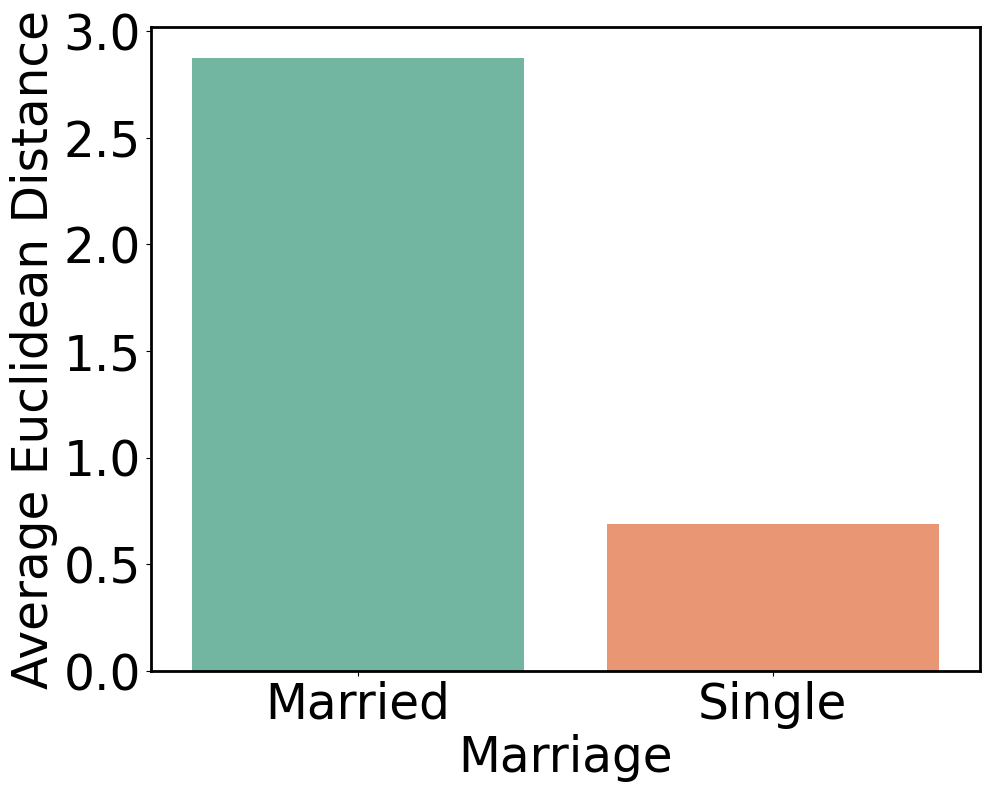

In [25]:
df_combined['Marriage Label'] = df_combined['MARRIAGE'].map({1: 'Married',2: 'Single'})
df_grouped = df_combined.groupby('Marriage Label')['euclidean_distance'].mean().reset_index()

plt.figure(figsize=(10,8))
sns.barplot(data=df_grouped, x='Marriage Label', y='euclidean_distance', palette='Set2')

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)    
plt.xlabel("Marriage",fontsize=35)
plt.ylabel("Average Euclidean Distance",fontsize=35)
ax = plt.gca()

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()


In [26]:
df_grouped

,Marriage Label,euclidean_distance
0,Married,2.873906
1,Single,0.689516


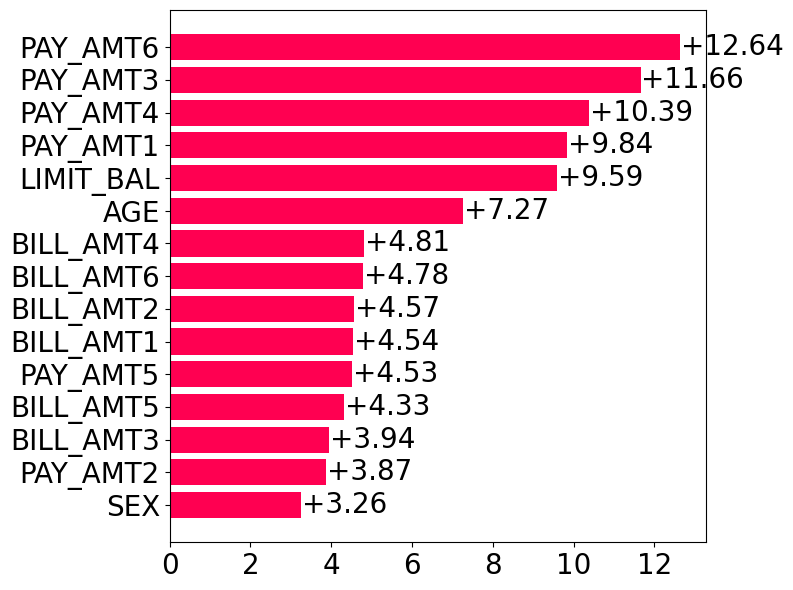

In [27]:

feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

plt.figure(figsize=(8, 6))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
      
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
plt.savefig("feature_contribution_plot_balance.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


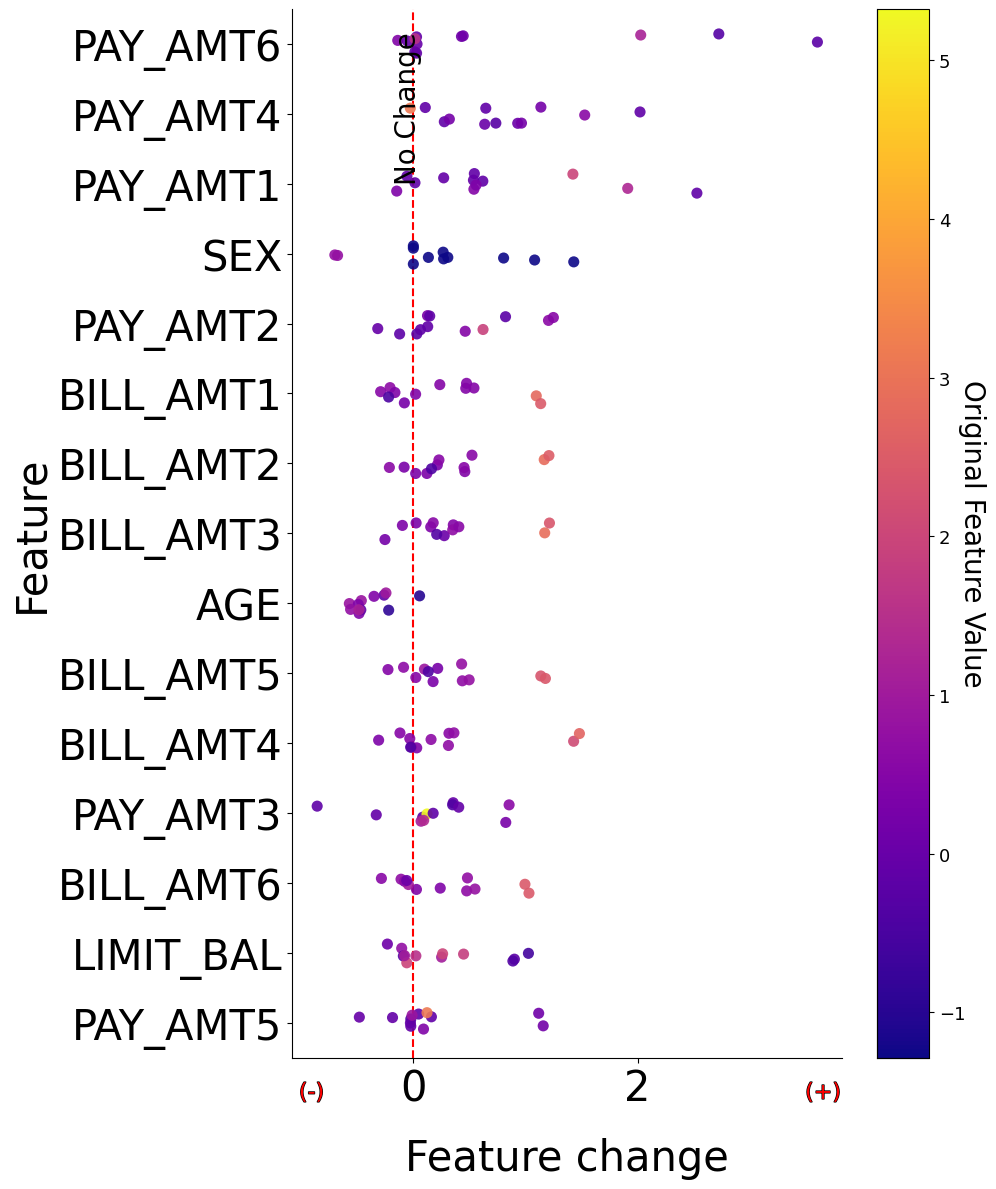

In [29]:
records = []
for feature in feature_summary["Feature"]:
    factual_values = df_combined[feature].values
    cf_values = df_combined[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

df = pd.DataFrame(records)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

plt.figure(figsize=(10, 12))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order  
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_credit.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [31]:
df_married = df_combined[df_combined['MARRIAGE'] == 1]
df_single = df_combined[df_combined['MARRIAGE'] == 2]


In [33]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

# Step 1: Identify which features actually changed
changed = df_married[cf_feature_cols].values != df_married[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_married[cf_feature_cols].values - df_married[feature_cols].values) ** 2
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

# Step 4: Average contribution of each feature to total distance
avg_contributions = contributions.mean(axis=0)

# Step 5: Combine into a summary DataFrame
feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]


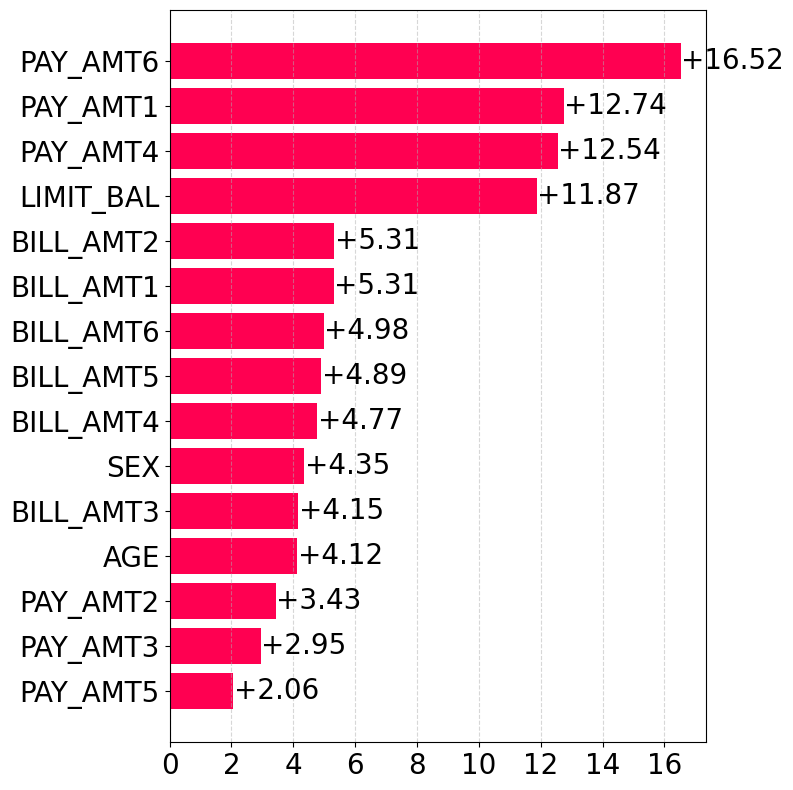

In [34]:
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

# Plot
plt.figure(figsize=(8, 8))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("feature_contribution_plot_balance_credit_married.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


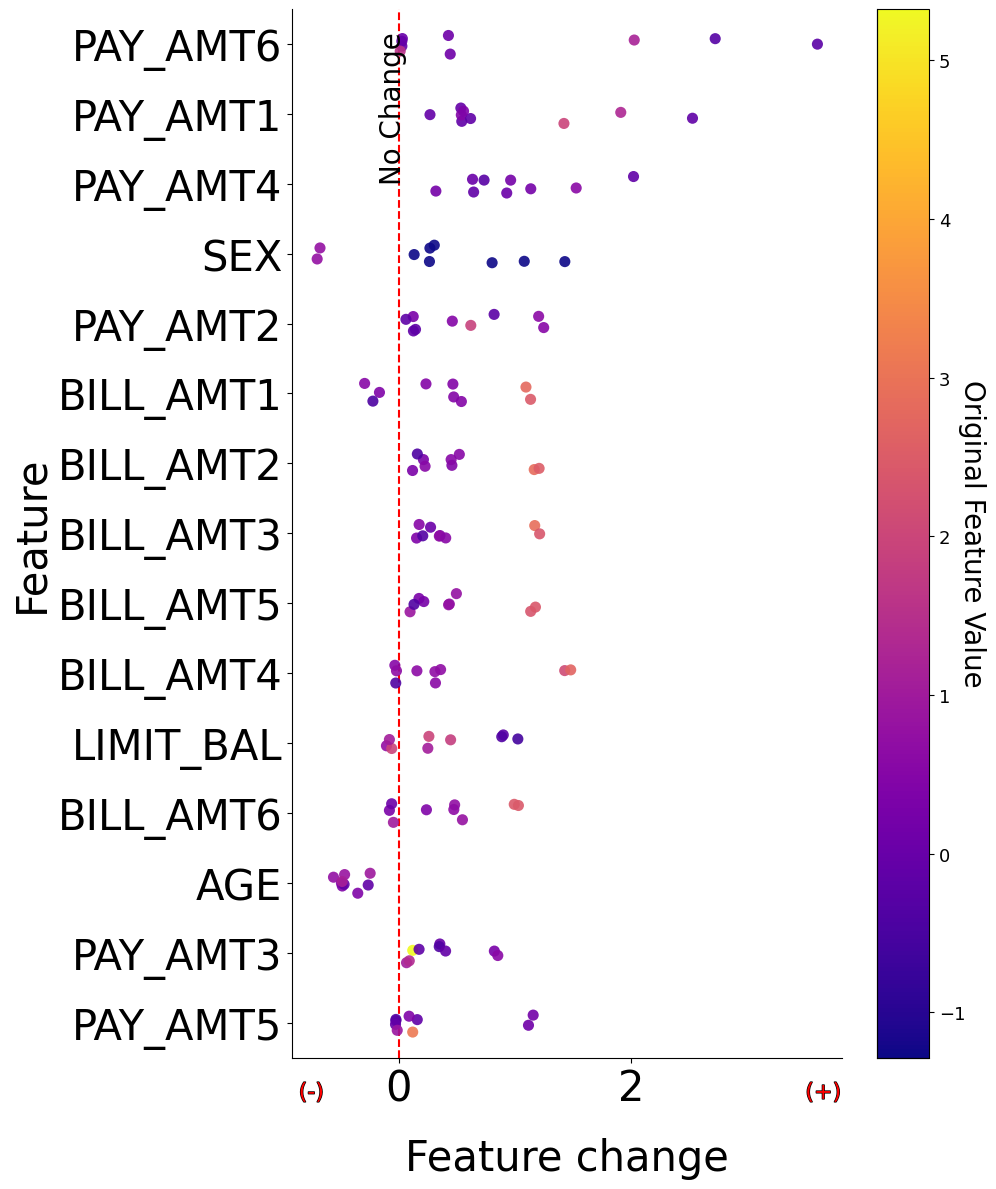

In [37]:
records = []
for feature in feature_summary["Feature"]:
    factual_values = df_married[feature].values
    cf_values = df_married[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

df = pd.DataFrame(records)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

plt.figure(figsize=(10, 12))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order  # dynamic order
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_married.pdf", format="pdf", bbox_inches="tight")
plt.show()


### SINGLE EXPLANATION

In [38]:
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

# Step 1: Identify which features actually changed
changed = df_single[cf_feature_cols].values != df_single[feature_cols].values
change_counts = changed.sum(axis=0)

# Step 2: Get squared distances per feature
squared_diffs = (df_single[cf_feature_cols].values - df_single[feature_cols].values) ** 2
# Step 3: Normalize contribution by total distance (avoid divide-by-zero)
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

# Step 4: Average contribution of each feature to total distance
avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]


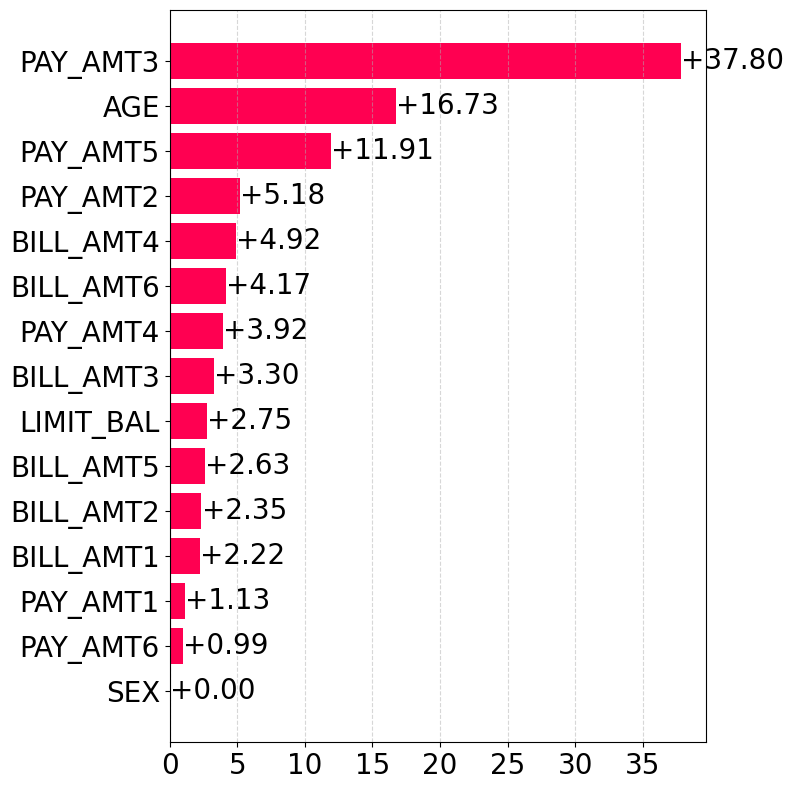

In [39]:
import matplotlib.pyplot as plt

# Sort feature summary again just in case
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

# Plot
plt.figure(figsize=(8, 8))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

# Annotate values like "+0.94"
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
# Style
#plt.title("Feature Contribution to Counterfactual Cost")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("feature_contribution_plot_balance_bank_single.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


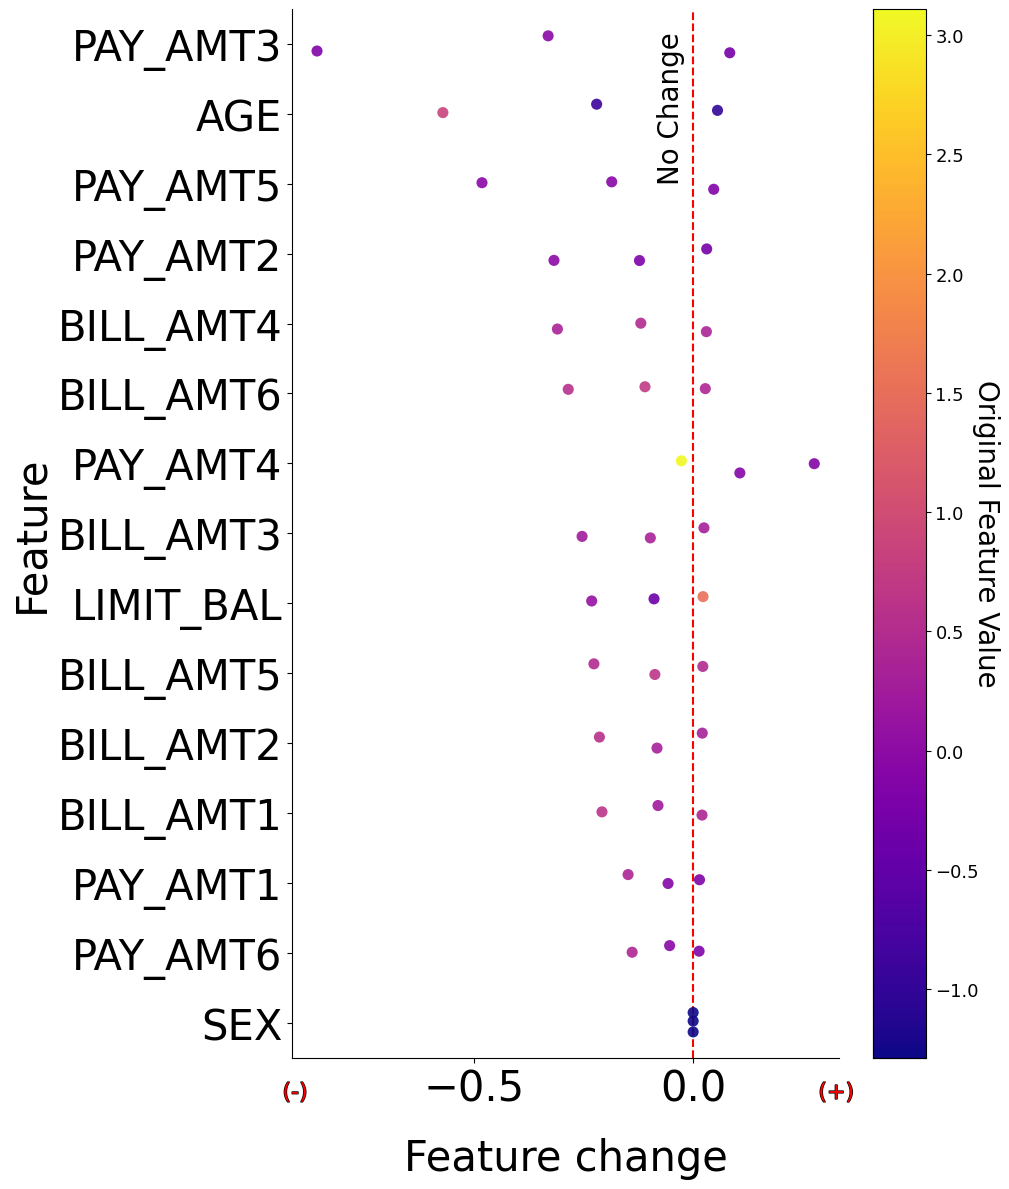

In [41]:
records = []
for feature in feature_summary["Feature"]:
    factual_values = df_single[feature].values
    cf_values = df_single[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

# Convert to DataFrame
df = pd.DataFrame(records)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Normalize color scale based on factual values
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

# Plot
plt.figure(figsize=(10, 12))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order  # dynamic order
)
# Colorbar setup
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

# Labels
ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

# Annotate changes
decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

# Vertical zero line and annotation
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_credit_single.pdf", format="pdf", bbox_inches="tight")

plt.show()
